In [4]:
import numpy as np
#import gromacs
import pandas as pd
import os, fnmatch
import matplotlib.pyplot as plt
from IPython.display import display


def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result


def symmetrize(a):
    """ 
    a - array to be symmetrized mirror-like, with the mirror symmetry placed in the centre
    returns: a tuple with the symmetrized array (half the size), 
             and the resulting standard deviation in the second place of the tuple
    """
    d = a.shape[0]   #assuming index=0
    m = d//2         # the middle-of-array index -- integer division here
    l = a[:m]        # left part
    r = np.ndarray(l.shape)
    for i in range(m):
        r[i] = a[-i-1]
    s = np.average(np.vstack((l, r)), axis=0)
    e = np.std(np.vstack((l, r)), axis=0)
    return (s, e)


In [5]:
# find all awh_t....xvg files
awh_files = find('awh_t*.xvg', os.curdir)

use_symmetry = True

# get the simulation results from the last awh_t... resp friction_t... files and the APL
simulations = {}
apls  = []
aplstderrs = []
means = []
dgs   = []
dgstds= []
stds  = []
perms    = []
permstds = []
surfexcs = []
bendings = []
tilts    = []
compress = []
thicks   = []

m = 10  # begin-end index to cut the edges of the profile

for i in range(8):  # find the no.... newest files
    newest_file = max(awh_files, key=os.path.getctime)
    print(newest_file)
    newest_dirname = os.path.dirname(newest_file)
    try:
        awh_data  = np.loadtxt(newest_file, comments=("#", "@"))
        fric_data = np.loadtxt(newest_file.replace("awh_", "friction_"), comments=("#", "@"))
        x    = awh_data[:,0]
        fep  = awh_data[:,1]
        fric = fric_data[:,1]
        # OVERRIDING friction data with a constant number
        #fric = np.ones(fep.shape)*2900.0
        # obtain the estimate of deltaG
        dg1   = np.max(fep-fep[-m:].mean())
        dg2   = np.max(fep-fep[:m].mean())
        dgs.append(np.mean([dg1, dg2]))
        dgstds.append(np.std([dg1, dg2]))
        if use_symmetry:
            fepsymm  = symmetrize(fep)
            fricsymm = symmetrize(fric)
            xsymm    = x[:fepsymm[0].shape[0]]
            rxsymm    = np.exp(fepsymm[0]-fepsymm[0][:m].mean())*fricsymm[0]/1000.0    # r(x)
            #rxstdsymm = ( np.exp(fepsymm[0])*fricsymm[1] + np.exp(fepsymm[1])*fricsymm[0] )/1000.0    # error of r(x) through chain rule
            # OVERRIDING error estimate of friction here
            rxstdsymm = ( np.exp(fepsymm[0])*100.0 + np.exp(fepsymm[1])*fricsymm[0] )/1000.0    # error of r(x) through chain rule
            r         = np.trapz(x=xsymm[m:], y=rxsymm[m:]) *2.0   # *2, because i have only half of the profile after symmetrizing it
            rstd      = np.trapz(x=xsymm[m:], y=rxstdsymm[m:]) *2.0
            perm      = 1000.0/r   # in nm/us resp mm/s
            permstd   = perm**2 * rstd /1000.0   # is the same as: perm*rstd/r
            simulations[newest_dirname] = r
            means.append(r)
            stds.append(rstd)
            perms.append(perm)
            permstds.append(permstd)
        else:
            # set the zero-level (solvent) to 0 from one resp. other side
            rx1  = np.exp(fep-fep[-m:].mean())*fric/1000.0    # r(x) ...
            rx2  = np.exp(fep-fep[:m].mean()) *fric/1000.0    # resistance in ns/nm resp s/m
            r = np.trapz(x=x[m:-m], y=np.vstack((rx1, rx2))[:,m:-m])
            simulations[newest_dirname] = r.mean()
            means.append(r.mean())
            stds.append(r.std())
        try:
            apl = np.loadtxt(newest_dirname+"/apl.dat")
        except IOError:
            print("Problems loading the APL file in dir {} with np.loadtxt".format(newest_dirname))
            apl = None
        except:
            print("Generally some problems in the apl loading -- check code.")
        finally:
            # this is now read from lipidator output (see below)
            #apls.append(apl)
            pass
        # adding Surface excess
        try:
            with open(newest_dirname+"/surf_excess_wat_ethanol.dat", "r") as sefile:
                line = sefile.readline()
                surfexcess = float(line.split()[-2])
        except IOError:
            print("Problems loading the surface excess file in dir {}".format(newest_dirname))
            surfexcess = None
        except:
            print("Generally some problems in the Surface excess loading -- check code.")
            surfexcess = None
        finally:
            surfexcs.append(surfexcess)
        # adding Luzzati thickness from density profile xvg file
        try:
            dens_arr = np.loadtxt(newest_dirname+"/density_ethanol_water.xvg", comments=["#", "@"])
            wat = dens_arr[:,2]
            x   = dens_arr[:,0]
            d_z = np.abs(x[-1]-x[0])
            bulkwatdens = np.mean(wat[:10])
            wat /= bulkwatdens
            h   = d_z - np.trapz(wat, x)
            #print(x, wat, bulkwatdens, d_z, h)
        except IOError:
            print("Problems loading the density_ethanol_water XVG file in dir {}".format(newest_dirname))
            h = None
        except:
            print("Generally some problems in the density_ethanol_water loading resp. Luzzati thickness calc -- check code.")
            h = None
        finally:
            thicks.append(h)
        # adding Compressibility modulus from Box-x xvg file
        try:
            x_t = np.loadtxt(newest_dirname+"/boxx.xvg", comments=["#", "@"])
            a_t = x_t**2
            a_0 = a_t.mean(axis=0)[1]
            dev = a_t-a_0
            var =  np.var(dev, axis=0)[1]
            ka = a_0/var
        except IOError:
            print("Problems loading the box-x XVG file in dir {}".format(newest_dirname))
            ka = None
        except:
            print("Generally some problems in the Box-x loading/calc -- check code.")
            ka = None
        finally:
            compress.append(ka)
        # adding bending and tilt modulus from lipidator
        try:
            with open(newest_dirname+"/lipidator.out", "r") as lefile:
                for line in lefile.readlines():
                    linesplit = line.split()
                    if line.startswith("Monolayer Bending"):
                        bending = float(linesplit[linesplit.index('kappa')+1])
                    if line.startswith("Bilayer Tilt"):
                        tilt    = float(linesplit[linesplit.index('kappa')+1])
                    if line.startswith(" Area AVG"):
                        apl       = float(linesplit[linesplit.index('[bilayer]:')+1]) *0.01
                        aplstderr = float(linesplit[linesplit.index('[bilayer]:')+4]) *0.01
                        aplstdev  = float(linesplit[linesplit.index('[bilayer]:')+6]) *0.01
                        
        except IOError:
            print("Problems loading the lipidator file in dir {}".format(newest_dirname))
            bending = tilt = None
        except:
            print("Generally some problems in loading Lipidator output -- check code.")
        finally:
            try:
                bendings.append(bending)
                tilts.append(tilt)
                apls.append(apl)
                aplstderrs.append(aplstderr)
            except:
                bendings.append(None)
                tilts.append(None)
                apls.append(None)
                aplstderrs.append(None)
    except IOError:
        print("Problems loading file {} (or its friction_ counterpart) with np.loadtxt".format(newest_file))
    #except:
    #    print("Some other problem occured -- investigate in the code...")
    finally:    
        # clean the other awh-files, which were found in the same folder
        awh_files = [ f for f in awh_files if os.path.dirname(f) != newest_dirname]


ValueError: max() arg is an empty sequence

In [3]:
pdsims_all = pd.DataFrame([(r, std, dg, dgstd, apl, aplstd, p, pstd, surfex, bend, til, compr, thick) 
                           for (r, std, dg, dgstd, apl, aplstd, p, pstd, surfex, bend, til, compr, thick) 
                           in zip(means, stds, dgs, dgstds, apls, aplstderrs, perms, permstds, surfexcs, bendings, tilts, compress, thicks)], 
                          index=simulations.keys(), 
                          columns=["resistance ns/nm", "r std", "deltaG kT", "dG std", "APL nm2", "APL stderr", 
                                   "perm nm/us", "perm std", "surfexc nm-2",
                                   "Bending modulus kT", "Tilt modulus kT/nm2", "Compressibility modulus kT/nm2",
                                   "thickness nm"])

In [4]:
pdsims = pdsims_all

In [5]:
pdsims.sort_values(by="perm nm/us")

,resistance ns/nm,r std,deltaG kT,dG std,APL nm2,APL stderr,perm nm/us,perm std,surfexc nm-2,Bending modulus kT,Tilt modulus kT/nm2,Compressibility modulus kT/nm2,thickness nm
./DNPC_di-C24-C26-1/awh-perm,3599.130157,222.212551,5.845824,0.195652,0.650363,0.000149,0.277845,0.017154,None,11.5620,23.7640,86.887427,5.007429
./DGPC_di-C20-C22-1/awh-perm,2381.956267,138.008642,5.469992,0.315903,0.654579,0.000185,0.419823,0.024324,None,14.7264,23.3837,77.109762,4.463948
./DOPC_di-C16-C18-1/awh-perm,1041.657754,115.896809,5.250605,0.136105,0.659611,0.000190,0.960008,0.106812,None,12.9827,19.8708,68.086306,3.645674
./DYPC_di-C12-C14-1/awh-perm,502.410675,68.942308,4.642096,0.050397,0.634132,0.000172,1.990404,0.273129,None,13.7143,21.4417,68.355247,3.127697


## Saving into CSVs

as there lots of rubbish in the table 
and we are only interested in the prermeabilities, 
let's select only Perm and its error estimate.

In [8]:
pdsims.to_csv("list_of_simulations_all_values.csv")

In [15]:
permsdf = pdsims.loc[:,"perm nm/us" : "perm std"].sort_values(by="perm nm/us")

Save the actual permeabilities into a CSV:

In [7]:
permsdf.to_csv("list_of_simulations_permeability-tail-length.csv")

# Continue here after loading data from CSV in the last cell

Calculate relative permeabilities – normalized to the thinnest membrane (last after sorting)

In [16]:
# get the relative permeability error estimate
permsdf["perm relerr"] = permsdf.loc[:, "perm std"] / permsdf.loc[:, "perm nm/us"]

permsdfrel = permsdf.drop(columns="perm std")

In [29]:
permsdfrel.loc[:, "perm nm/us"] /= permsdfrel.loc["./DYPC_di-C12-C14-1/awh-perm", "perm nm/us"]

KeyError: './DYPC_di-C12-C14-1/awh-perm'

In [31]:
permsdfrel

,perm nm/us,perm relerr
2,0.277845,0.061741
3,0.419823,0.057939
1,0.960008,0.111262
0,1.990404,0.137223


Save the relative permeabilities into a CSV:

In [19]:
permsdfrel.to_csv("list_of_simulations_permeability-tail-length-relative.csv")

<AxesSubplot:>

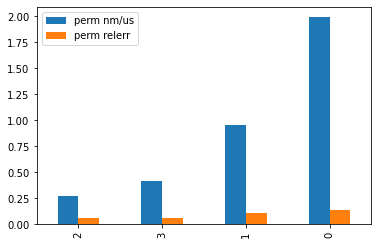

In [19]:
permsdfrel.plot.bar()

## Plot (normalized) Permeability as a function of thickness

In [16]:
# make a new dataframe
relperdf = pdsims.sort_values(by="perm nm/us")

# get the relative permeability (+error estimate) from existing DF
relperdf["perm rel"] = permsdfrel["perm nm/us"]
relperdf["perm relerr"] = permsdf["perm relerr"]

In [17]:
relperdf

,resistance ns/nm,r std,deltaG kT,dG std,APL nm2,APL stderr,perm nm/us,perm std,surfexc nm-2,Bending modulus kT,Tilt modulus kT/nm2,Compressibility modulus kT/nm2,thickness nm,perm rel,perm relerr
./DNPC_di-C24-C26-1/awh-perm,3599.130157,222.212551,5.845824,0.195652,0.650363,0.000149,0.277845,0.017154,None,11.5620,23.7640,86.887427,5.007429,0.139592,0.061741
./DGPC_di-C20-C22-1/awh-perm,2381.956267,138.008642,5.469992,0.315903,0.654579,0.000185,0.419823,0.024324,None,14.7264,23.3837,77.109762,4.463948,0.210924,0.057939
./DOPC_di-C16-C18-1/awh-perm,1041.657754,115.896809,5.250605,0.136105,0.659611,0.000190,0.960008,0.106812,None,12.9827,19.8708,68.086306,3.645674,0.482318,0.111262
./DYPC_di-C12-C14-1/awh-perm,502.410675,68.942308,4.642096,0.050397,0.634132,0.000172,1.990404,0.273129,None,13.7143,21.4417,68.355247,3.127697,1.000000,0.137223


In [20]:
import seaborn as sns

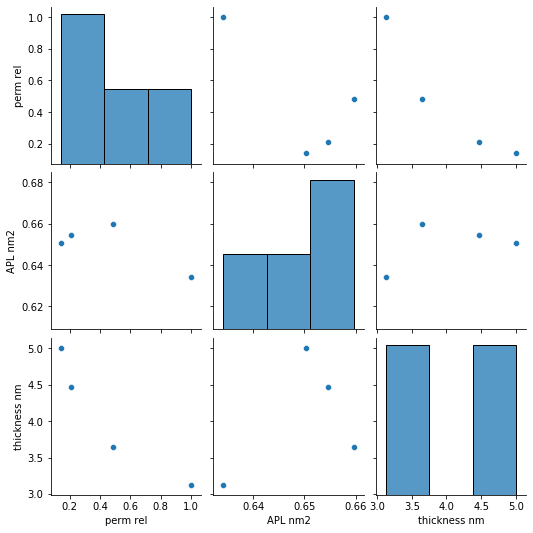

In [27]:
# a quick pairplot of relevant features to see the dataset roughly...
sns.pairplot(relperdf[["perm rel", "APL nm2", "thickness nm"]])

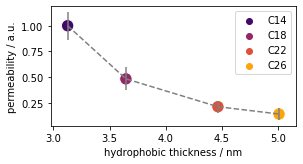

In [110]:
#sns.lmplot(data=relperdf, x="thickness nm", y='perm rel')
fig = plt.figure(figsize=[4.4,2.2])
plt.errorbar(data=relperdf.sort_values(by="thickness nm"), x="thickness nm", y='perm rel', yerr="perm relerr", 
             label=None,
             marker=None,
             ls="--", color='grey')
sns.scatterplot(data=relperdf.sort_values(by="thickness nm"), x="thickness nm", y='perm rel', 
                hue=["C14", "C18", "C22", "C26"], hue_order=["C14", "C18", "C22", "C26"],
                palette='inferno',
                markers="s", s=155)
plt.xlabel("Hydrophobic thickness (nm)")
plt.ylabel("Permeability (a.u.)")

plt.savefig("rel-perm-thickness_plot.png", dpi=300, bbox_inches='tight')

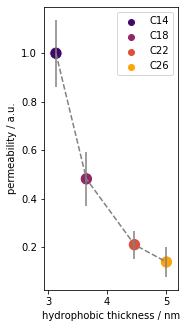

In [113]:
#sns.lmplot(data=relperdf, x="thickness nm", y='perm rel')
fig = plt.figure(figsize=[2.4,5.2])
plt.errorbar(data=relperdf.sort_values(by="thickness nm"), x="thickness nm", y='perm rel', yerr="perm relerr", 
             label=None,
             marker=None,
             ls="--", color='grey')
sns.scatterplot(data=relperdf.sort_values(by="thickness nm"), x="thickness nm", y='perm rel', 
                hue=["C14", "C18", "C22", "C26"], hue_order=["C14", "C18", "C22", "C26"],
                palette='inferno',
                markers="s", s=155)
plt.xlabel("Hydrophobic thickness (nm)")
plt.ylabel("Permeability (a.u.)")

plt.savefig("rel-perm-thickness_plot_vertical.png", dpi=300, bbox_inches='tight')

In [1]:
#sns.lmplot(data=relperdf, x="thickness nm", y='perm rel')
fig = plt.figure(figsize=[4.4,2.2])
plt.errorbar(data=relperdf.sort_values(by="APL nm2"), x="APL nm2", y='perm rel', yerr="perm relerr", 
             label=None,
             marker=None,
             ls="", color='grey')
sns.scatterplot(data=relperdf.sort_values(by="APL nm2"), x="APL nm2", y='perm rel', 
                hue=["C14", "C26", "C22", "C18"], hue_order=["C14", "C18", "C22", "C26"],
                palette='inferno',
                markers="s", s=155)
plt.xlabel(r"Lipid surface area (nm$^2$)")
plt.ylabel("Permeability (a.u.)")
plt.xlim([0.625,0.665])
plt.legend(loc='lower left')

plt.savefig("rel-perm-APL_plot.png", dpi=300, bbox_inches='tight')

NameError: name 'plt' is not defined

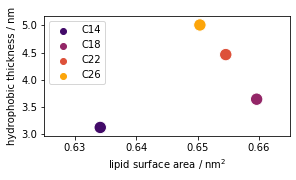

In [112]:
#sns.lmplot(data=relperdf, x="thickness nm", y='perm rel')
fig = plt.figure(figsize=[4.4,2.2])
sns.scatterplot(data=relperdf.sort_values(by="APL nm2"), x="APL nm2", y="thickness nm", 
                hue=["C14", "C26", "C22", "C18"], hue_order=["C14", "C18", "C22", "C26"],
                palette='inferno',
                markers="s", s=155)
plt.xlabel(r"Lipid surface area (nm$^2$)")
plt.ylabel("Permeability (a.u.)")
plt.xlim([0.625,0.665])
plt.legend(loc='upper left')

plt.savefig("thickness-APL_plot.png", dpi=300, bbox_inches='tight')

In [12]:
# Data Loading for re-plotting...

permsdf = pd.read_csv("list_of_simulations_permeability-tail-length-relative.csv")

pdsims  = pd.read_csv("list_of_simulations_all_values.csv")